## EDA
### 라이브러리

In [22]:
import os
import json
from glob import glob

import matplotlib.pyplot as plt
from collections import Counter

### 경로

In [23]:
image_dir = "../data/train/DCM"
json_dir = "../data/train/outputs_json" 

### Class 분포
#### - Class별 개수

Text(0, 0.5, 'Count')

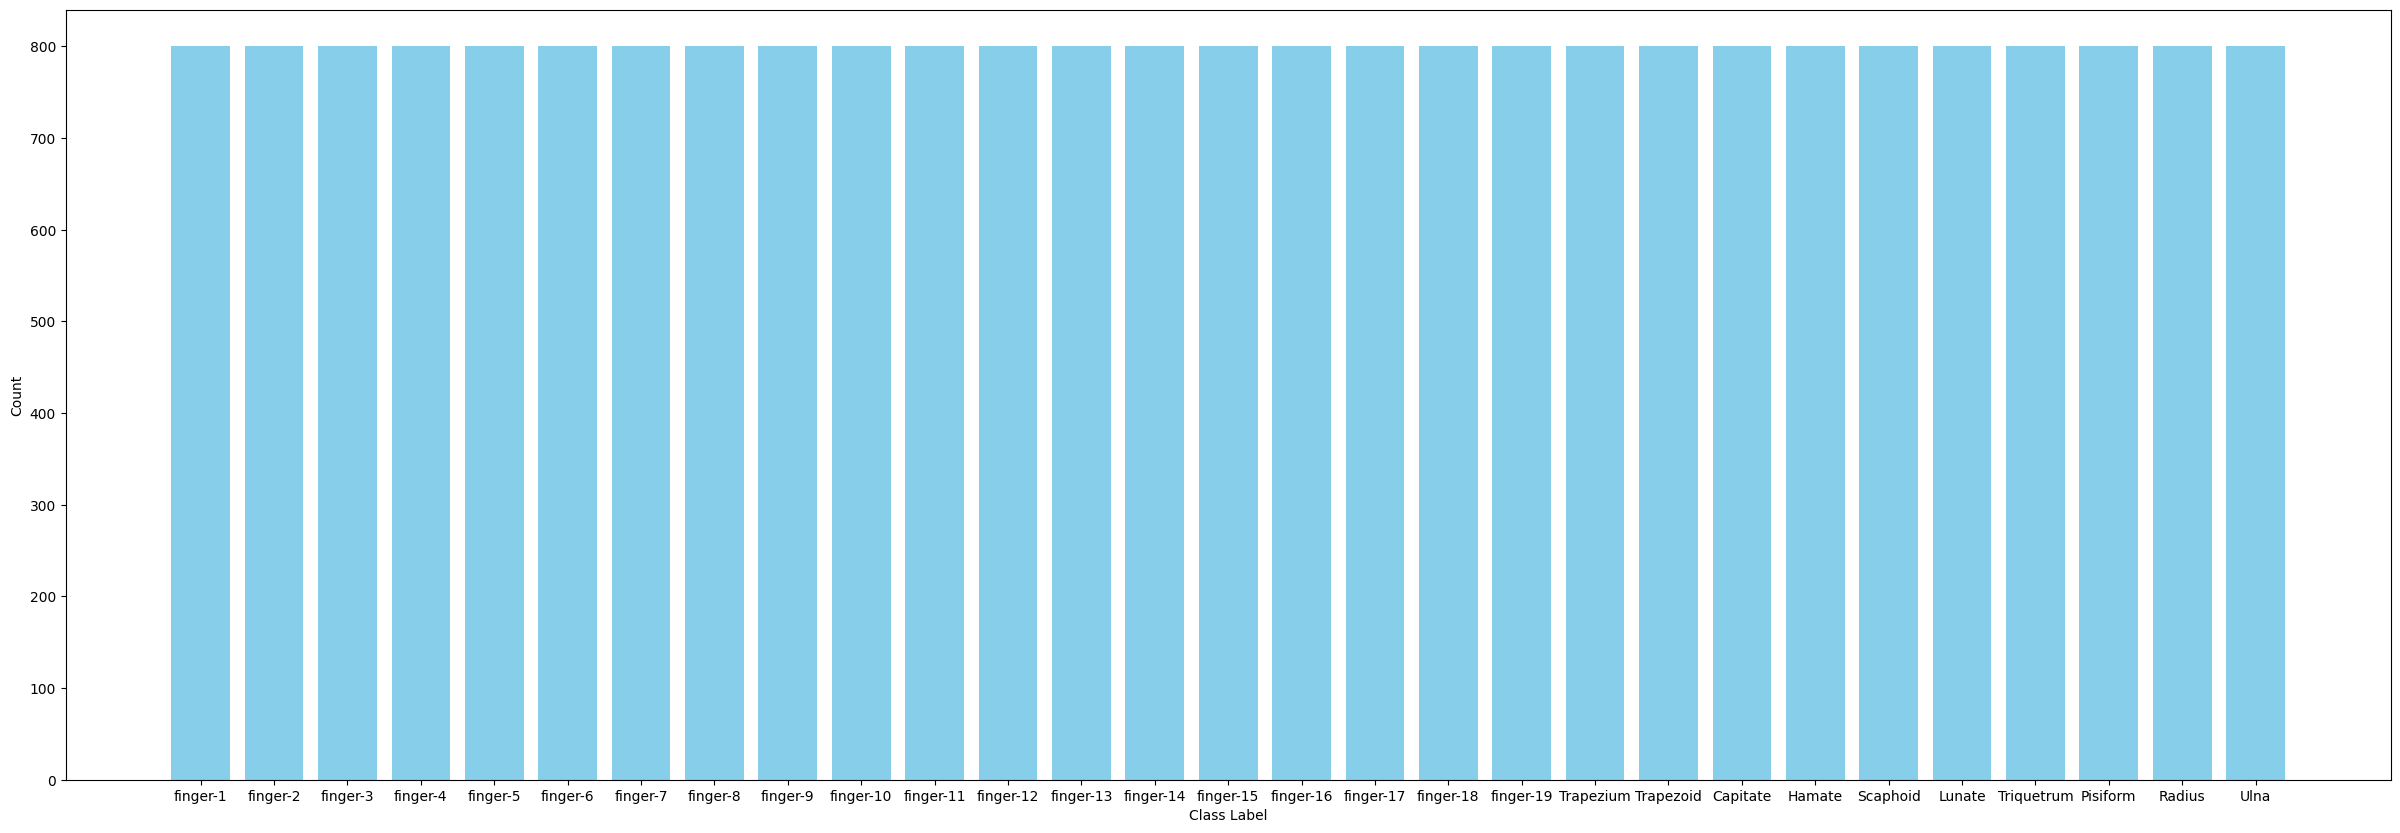

In [24]:
label_counts = Counter()

for json_file in glob(os.path.join(json_dir, "**", "*.json"), recursive=True):
    with open(json_file, "r", encoding="utf-8") as file:
        data = json.load(file)
        label_counts.update(annotation['label'] for annotation in data['annotations'])

plt.figure(figsize=(30, 10))
plt.bar(label_counts.keys(), label_counts.values(), color="skyblue")
plt.xlabel("Class Label")
plt.ylabel("Count")


#### - Class별 pixel 차지 비율

#### - 이미지 당 29개의 클래스 유무 확인

### 메타데이터 분포
#### - 나이, 성별, 몸무게, 키 분포
#### - 성별에 따른 나이, 몸무게, 키 분포

#### - 나이, 성별에 따른 뼈의 밀도 분포

#### - 키에 따른 뼈 면적 분포